In [29]:
import numpy as np
# import glob2 as glob
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle

In [30]:
def load_data(data_path, indices=[]):
#     file_names = glob.glob(data_path)
    file_names = sorted(os.listdir(data_path))
    print(file_names)
    for fidx, file_name in enumerate(file_names):
        if fidx in indices:
            data_for_file = pickle.load(open(os.path.join(data_path, file_name), 'rb'))
            yield data_for_file
#             data.append(data_for_file)
#     data = np.concatenate(data, axis=1)
#     reduced_data = np.empty((data.shape[0], int(data.shape[1] / AVERAGING_SIZE)))
#     for k in range(0, data.shape[1], AVERAGING_SIZE):
#         reduced_data[:, int(k / AVERAGING_SIZE)] = data[:, k:k + AVERAGING_SIZE].mean(axis=1)
#     return data

In [31]:
state_data = load_data(
    '../data/rl_agent_outputs/det_reward_to_stoch_many_reward_sites_2024-08-15_09_27_20_718621/state',
    indices=[34]
)

d = None

for data in state_data:
    d = data

['00001.pkl', '00002.pkl', '00003.pkl', '00004.pkl', '00005.pkl', '00006.pkl', '00007.pkl', '00008.pkl', '00009.pkl', '00010.pkl', '00011.pkl', '00012.pkl', '00013.pkl', '00014.pkl', '00015.pkl', '00016.pkl', '00017.pkl', '00018.pkl', '00019.pkl', '00020.pkl', '00021.pkl', '00022.pkl', '00023.pkl', '00024.pkl', '00025.pkl', '00026.pkl', '00027.pkl', '00028.pkl', '00029.pkl', '00030.pkl', '00031.pkl', '00032.pkl', '00033.pkl', '00034.pkl', '00035.pkl', '00036.pkl', '00037.pkl', '00038.pkl']


/var/folders/rp/n8h2l6w51774kxnq18z19s8r0000gn/T/ipykernel_1313/1030212406.py:38: RuntimeWarning: divide by zero encountered in divide
  axs.plot(np.arange(len(all_dwell_times)), 1/np.array(all_dwell_times), c='black')


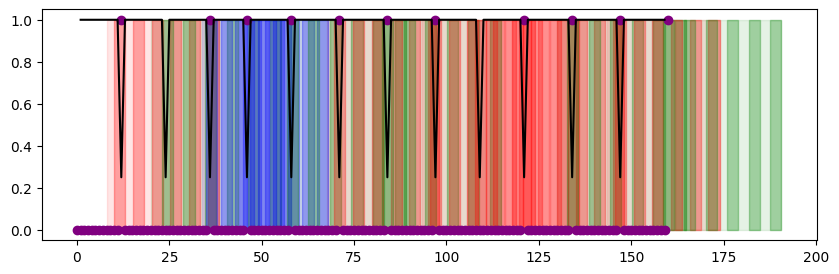

In [32]:
all_patch_bounds = []
all_reward_site_bounds = []
all_patch_nums = []
all_actions = []
all_positions = []
all_rewards = []

colors = ['r', 'b', 'g']

env_idx = 11

for k in np.arange(len(d)):
    all_patch_bounds.append(d[k]['current_patch_bounds'][env_idx])
    all_reward_site_bounds.append(d[k]['reward_bounds'][env_idx])
    all_patch_nums.append(d[k]['current_patch_num'][env_idx])
    all_actions.append(d[k]['action'][env_idx])
    all_positions.append(d[k]['current_position'][env_idx])
    all_rewards.append(d[k]['reward'][env_idx])
    
      
scale = 1
fig, axs = plt.subplots(1, 1, figsize=(10 * scale, 3 * scale))

all_dwell_times = []
rewards_at_positions = [0]
dwell_time = 0
last_p = None
for i, p in enumerate(all_positions):
    if last_p is not None and (p != last_p):
        all_dwell_times.append(dwell_time)
        rewards_at_positions.append(0)
        dwell_time = 0
    if last_p is not None:
        dwell_time += 1
    rewards_at_positions[-1] += all_rewards[i]
    last_p = p

axs.plot(np.arange(len(all_dwell_times)), 1/np.array(all_dwell_times), c='black')
axs.scatter(np.arange(len(rewards_at_positions)), rewards_at_positions, c='purple')

last_pb = None
for i, pb in enumerate(all_patch_bounds):
    if last_pb is None or (pb != last_pb).any():
        axs.fill_between(pb, np.zeros(2), np.ones(2), alpha=0.1, color=colors[all_patch_nums[i]], zorder=-2)
        last_pb = pb
        for rwsb in all_reward_site_bounds[i]:
            axs.fill_between(rwsb, np.zeros(2), np.ones(2), alpha=0.3, color=colors[all_patch_nums[i]], zorder=-1)
    